In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from wordcloud import wordcloud
%matplotlib inline

In [32]:
#!pip install matplotlib wordcloud

wordcloud - there are words (genera of movies), frequnecy o

In [33]:
#### READING ANIMELIST.CSV

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+ "/animelist.csv", low_memory=True,usecols=["user_id","anime_id","rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
rating_df.shape

(5000000, 3)

In [7]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 114.4 MB


#### DATA PROCESSING

Focus on active user (frequent) who have watched the anime in high frequency as they will help in our recommendation more efficiently 

In [8]:
n_rating = rating_df.user_id.value_counts()

In [9]:
n_rating # user_id 11100  has given 14429 number of ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
13465        1
16480        1
16465        1
3465         1
16450        1
Name: count, Length: 15186, dtype: int64

Remove infrequent users, keep on user who has rated more than 400 anime

In [10]:
rating_df = rating_df[rating_df["user_id"].isin(n_rating[n_rating >=400].index)].copy()

In [11]:
len(rating_df)

3246641

In [12]:
min_rating = min(rating_df['rating'])

In [13]:
max_rating = max(rating_df['rating'])

In [14]:
average_rating = np.mean(rating_df['rating'])

In [15]:
min_rating,max_rating,average_rating

(0, 10, np.float64(4.122732695114736))

MinMax Scaling Rating column

In [16]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x - min_rating)/(max_rating - min_rating)).values.astype(np.float64)

In [17]:
rating_df['rating'].max(), rating_df['rating'].mean()

(np.float64(1.0), np.float64(0.4122732695114736))

In [18]:
rating_df.duplicated().sum()

np.int64(0)

In [19]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

Extract all the unique user_id into a list

In [20]:
users_ids = rating_df['user_id'].unique().tolist() 

In [21]:
user2user_encoded = {x: i for i,x in enumerate(users_ids)}

In [22]:
user2user_decoded = {i: x for i,x in enumerate(users_ids)}

In [23]:
#Mapping
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)

In [24]:
rating_df.head(3)

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0


In [25]:
n_users = len(user2user_encoded)
n_users  # experienced/ frequent users

4203

Encoding and decoding anime_id

In [26]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x: i for i,x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i,x in enumerate(anime_ids)}
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded)

In [27]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In our dataset we have 4203 users and 17149 unique anime

########### shuffle data

In [28]:
rating_df = rating_df.sample(frac=1, random_state=47).reset_index(drop=True)

In [29]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,15396,33486,0.9,3912,21
1,6562,1585,0.3,1649,7138


In [30]:
X = rating_df[['user','anime']].values
y = rating_df['rating']

In [31]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [32]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices:],
)

In [33]:
len(X_train), len(X_test)

(3245641, 1000)

In [34]:
type(X_train)

numpy.ndarray

2 separate arrays one for anime features an other for user features and then store them in a list

In [35]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [36]:
type(X_test_array)

list

In [37]:
type(X_test_array[0])

numpy.ndarray

#### MODEL ARCHITECTURE

In [38]:
def RecommenderNet():
    embedding_size = 128
    user = Input(name='user', shape=[1]) 

    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)
    
    anime = Input(name='anime', shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name='dot_product',normalize= True, axes=2)([user_embedding, anime_embedding]) # similarity b/w user embedding and anime embedding
    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x= BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs = [user,anime], outputs=x) # we made user and anime input different so that we can pass them as input

    model.compile(loss='binary_crossentropy', metrics=["mae","mse"], optimizer='Adam')

    return model

In [39]:
model  = RecommenderNet()

In [40]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [41]:
start_lr =0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000
ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr)/ ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr


In [42]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch),verbose=0)
checkpoint_filepath ='./weights.weights.h5' 

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                                   save_weights_only=True, monitor="val_loss",
                                   mode='min', save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min",
                               restore_best_weights=True )

In [43]:
mycallbacks =[model_checkpoint, lr_callback, early_stopping]

In [44]:
history = model.fit(x=X_train_array, y=y_train, batch_size= batch_size,
          epochs=20, verbose=1, validation_data = [X_test_array,y_test],
           callbacks = mycallbacks )

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - loss: 0.8017 - mae: 0.3823 - mse: 0.1976 - val_loss: 0.7425 - val_mae: 0.3792 - val_mse: 0.1817 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.7981 - mae: 0.3810 - mse: 0.1962 - val_loss: 0.7994 - val_mae: 0.3889 - val_mse: 0.2009 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.7921 - mae: 0.3787 - mse: 0.1939 - val_loss: 0.8015 - val_mae: 0.3891 - val_mse: 0.2014 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 0.7835 - mae: 0.3754 - mse: 0.1904 - val_loss: 0.7976 - val_mae: 0.3881 - val_mse: 0.2000 - learning_rate: 3.4000e-05


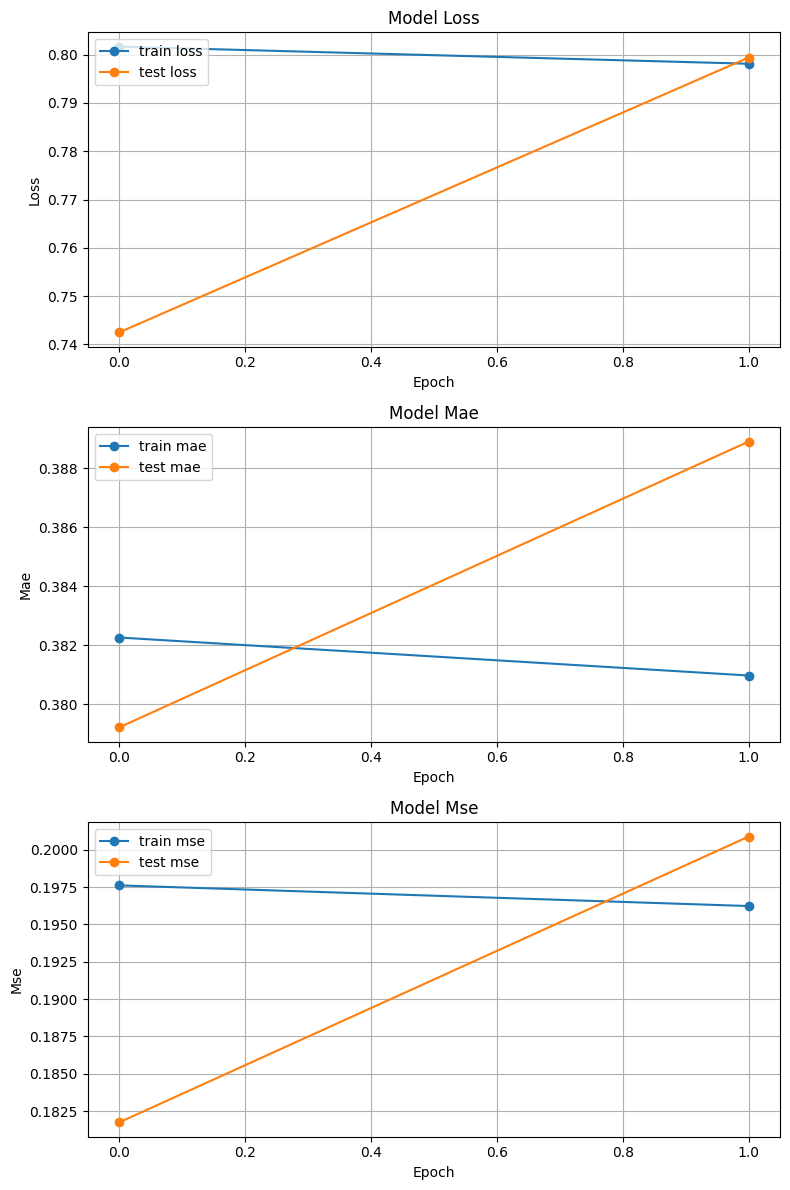

In [45]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

anime weights are stored in anime embedding and user weights are stored in user embedding, we have to extract that weight from anime embedding layer and user embedding layer

In [46]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/ np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [47]:
anime_weights = extract_weights("anime_embedding", model=model)

In [48]:
user_weights = extract_weights("user_embedding", model=model)

#### READING ANIME.CSV

MAL_ID = my anime list ID ; my anime list.net - data has been extracted from this website

In [49]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [50]:
df = df.replace("Unknown", np.nan)

In [51]:
# pass the anime id it will give the name of anime
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")

    return name     

In [52]:
df["anime_id"] = df.MAL_ID

In [53]:
df["English name"].unique()

array(['Cowboy Bebop', 'Cowboy Bebop:The Movie', 'Trigun', ...,
       'The Promised Neverland Season 2 Episode 5.5',
       'Immemorial Love For You 2nd Season',
       'Higurashi:When They Cry – SOTSU'], shape=(6831,), dtype=object)

In [54]:
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x: getAnimeName(x))

In [55]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie


In [56]:
getAnimeName(67)

'Basilisk'

In [57]:
getAnimeName(6702)

'Fairy Tail'

In [58]:
df.sort_values(by=['Score'], inplace=True, ascending=False,
               kind='quicksort', na_position='last' )

In [59]:
df[['Score', 'Name']].head(3)

,Score,Name
3971,9.19,Fullmetal Alchemist: Brotherhood
15926,9.17,Shingeki no Kyojin: The Final Season
5683,9.11,Steins;Gate


In [60]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [61]:
df = df[["anime_id", "eng_version","Score","Genres","Episodes","Type",
         "Premiered", "Members"]]
df.head(2)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [62]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]


In [63]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [64]:
getAnimeFrame("Trigun",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",26,TV,Spring 1998,558913


#### ANIME_WITH_SYNOPSIS.CSV

In [65]:
cols =["MAL_ID", "Name","Genres","sypnopsis"]

In [66]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)

In [67]:
synopsis_df.head(2)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."


In [68]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [69]:
getSynopsis(40028,synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

## CONTENT/ ITEM BASED RECOMMENDATION SYSTEM

In [70]:
pd.set_option("max_colwidth", None)

In [71]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


# CONTENT/ITEM BASED RECOMMENDATION

name- on which anime u want to pass recommendation (want similar recommendation), anime_weights (weights extracted from model), encoded and decoded of anime, n=10 number of recommendation u want, return_dist, neg=False (to find the most similar anime) if true will find the most dissimilar anime. 

In [72]:
pd.set_option("max_colwidth",None)

In [73]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df,synopsis_df, n=10, return_dist=False, neg=False): # return_dist= for similarity score
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    # here we will take the weight of nartu(anime) and compare it with the weight of all other anime 
    
    sorted_dists = np.argsort(dists) # least similar to most similar

    n = n + 1 # want the target anime to be included in the result

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:] # indexes of all similar anime will loop through it

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    # drop the input anime_id so that we dont get the anime we are searching to get similar anime
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

In [74]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=3
)

,name,similarity,genre
2,Ohayou! Spank,0.333659,"Slice of Life, Comedy"
1,Kaiketsu Zorori no Kyoufu no Hanayome Sakusen,0.331108,"Adventure, Comedy"
0,Neo Satomi Hakkenden: Satomi-chanchi no Hachi Danshi,0.328514,Comedy


## USER BASED RECOMMENDATION SYSTEM/ COLLABORATING FILTERING

**FOUND similar users**

In [75]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

In [76]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,3541,0.314706
8,15991,0.300267
7,7024,0.290702
6,12411,0.283989
5,5893,0.282040
4,5585,0.272015
3,4688,0.271442
2,13451,0.260547
1,16447,0.259366
0,1975,0.253092


In [77]:
from wordcloud import WordCloud

In [78]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [79]:
from collections import defaultdict

In [80]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [81]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list

In [82]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,15396,33486,0.9,3912,21
1,6562,1585,0.3,1649,7138


In [83]:
def get_user_preferences(user_id , rating_df , df , plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

# anime which are top rated by user
    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows

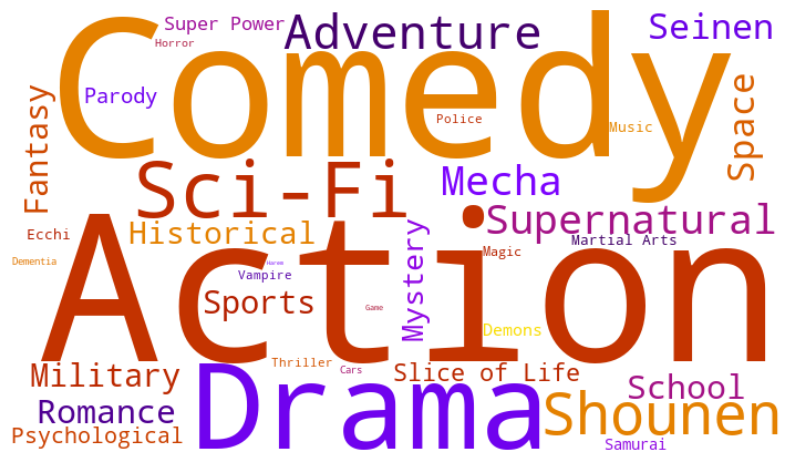

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [84]:
get_user_preferences(11880 , rating_df, df , plot=True)

**User based recommendation**

In [ ]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            


In [86]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [87]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

User recommendation for user 11880

In [88]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=3)

,n,anime_name,Genres,Synopsis
0,8,Your Name.,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture. One day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another. Kimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
1,8,Tokyo Ghoul,"Action, Mystery, Horror, Psychological, Supernatural, Drama, Seinen","Tokyo has become a cruel and merciless city—a place where vicious creatures called ""ghouls"" exist alongside humans. The citizens of this once great metropolis live in constant fear of these bloodthirsty savages and their thirst for human flesh. However, the greatest threat these ghouls pose is their dangerous ability to masquerade as humans and blend in with society. Based on the best-selling supernatural horror manga by Sui Ishida, Tokyo Ghoul follows Ken Kaneki, a shy, bookish college student, who is instantly drawn to Rize Kamishiro, an avid reader like himself. However, Rize is not exactly who she seems, and this unfortunate meeting pushes Kaneki into the dark depths of the ghouls' inhuman world. In a twist of fate, Kaneki is saved by the enigmatic waitress Touka Kirishima, and thus begins his new, secret life as a half-ghoul/half-human who must find a way to integrate into both societies."
2,8,The Devil is a Part-Timer!,"Comedy, Demons, Supernatural, Romance, Fantasy","Striking fear into the hearts of mortals, the Demon Lord Satan begins to conquer the land of Ente Isla with his vast demon armies. However, while embarking on this brutal quest to take over the continent, his efforts are foiled by the hero Emilia, forcing Satan to make his swift retreat through a dimensional portal only to land in the human world. Along with his loyal general Alsiel, the demon finds himself stranded in modern-day Tokyo and vows to return and complete his subjugation of Ente Isla—that is, if they can find a way back! Powerless in a world without magic, Satan assumes the guise of a human named Sadao Maou and begins working at MgRonald's—a local fast-food restaurant—to make ends meet. He soon realizes that his goal of conquering Ente Isla is just not enough as he grows determined to climb the corporate ladder and become the ruler of Earth, one satisfied customer at a time! Whether it's part-time work, household chores, or simply trying to pay the rent on time, Hataraku Maou-sama! presents a hilarious view of the most mundane aspects of everyday life, all through the eyes of a hapless demon lord."


# HYBRID RECOMMENDER SYSTEM

In [93]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommendation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 

In [94]:
hybrid_recommendation(11880)

['Your Name.', 'Tokyo Ghoul', 'The Devil is a Part-Timer!', 'Nisekoi:False Love', 'A Silent Voice', "KonoSuba:God's Blessing on This Wonderful World!", 'Attack on Titan', 'Overlord', 'Noragami:Stray God', 'Fate/Zero']


['Sore Ike! Anpanman',
 'Himitsukessha Taka no Tsume The Movie 3: http://takanotsume.jp wa Eien ni',
 'Your Name.',
 'Tokyo Ghoul',
 'The Devil is a Part-Timer!',
 'Nisekoi:False Love',
 'A Silent Voice',
 "KonoSuba:God's Blessing on This Wonderful World!",
 'Attack on Titan',
 'Overlord']

In [95]:
hybrid_recommendation(13994)

['Your Name.', 'Nisekoi:False Love', 'Yona of the Dawn', 'Maid Sama!', 'Black Butler', 'The Seven Deadly Sins', 'Angel Beats!', 'Soul Eater', 'Aldnoah.Zero', 'Princess Mononoke']


['Your Name.',
 'Nisekoi:False Love',
 'Yona of the Dawn',
 'Maid Sama!',
 'Black Butler',
 'The Seven Deadly Sins',
 'Angel Beats!',
 'Soul Eater',
 'Aldnoah.Zero',
 'Princess Mononoke']